In [1]:

from dwdweather import DwdWeather
from datetime import datetime

# create client
dw = DwdWeather()

# Find closest station to position
closest = dw.nearest_station(lon=7, lat=51)

# The hour you're interested in.
# The example is 2014-03-22 12:00 (UTC).
query_hour = datetime(2014, 3, 22, 12)

result = dw.query(station_id=closest["station_id"], hour=query_hour)


ModuleNotFoundError: No module named 'dwdweather'

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np


In [54]:
measurement = pd.read_csv("../../windmeasurement2.csv") 
forecast = pd.read_csv("../../windforecast2.csv") 
print(forecast)

FileNotFoundError: File b'../../windforecast2.csv' does not exist

In [75]:
path = "../../"
all_files = glob(join(path, "windmeasurement*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent
print(all_files)
df_from_each_file = (pd.read_csv(f) for f in all_files)
measurement   = pd.concat(df_from_each_file, ignore_index=True)

['../../windmeasurement2.csv', '../../windmeasurement.csv', '../../windmeasurement1.csv']


In [76]:
path = "../../"
all_files = glob(join(path, "windsuperforecast*.csv"))     # advisable to use os.path.join as this makes concatenation OS independent
print(all_files)
df_from_each_file = (pd.read_csv(f) for f in all_files)
forecast   = pd.concat(df_from_each_file, ignore_index=True)

['../../windsuperforecast2.csv', '../../windsuperforecast1.csv', '../../windsuperforecast.csv']


In [77]:
from datetime import datetime

runhour = 17

def SelectRunHour(data, runhour, keep = 'first'):
    selection = data['runtime'].dt.hour == runhour
    data = data[selection]
    # Delete duplicates
    data = data.sort_values(by =['runtime'], ascending = False)  
    data = data.drop_duplicates('forecast_time',keep = keep)  
    data = data.sort_values(by =['forecast_time'], ascending = False)  
    
    return data
    
def SelectRealForecast(data):
    posthoc = data['runtime'] < data['forecast_time']
    data = data[posthoc]
    return data

def SelectTimeRange(data, column, start_date, end_date):
    start_dates = data[column] > start_date
    end_dates = data[column] < end_date
    dates = start_dates & end_dates
    return data[dates]

def ResampleMean(data, column, time):
    data.index = data[column]
    data = data.resample(time).agg(['mean','max', 'min'])
    data[column] = data.index
    data.reset_index(drop=True, inplace=True)
    data.columns = ["_".join(x) for x in data.columns.ravel()]
    #data.columns = ['_'.join(col).strip() for col in data.columns.values]    

    for i,col in enumerate(data.columns):
        if col[-1] == "_":
            data.columns.values[i] = col[:-1]
    return data




In [78]:
measurement['runtime'] = pd.to_datetime(measurement['runtime'])
forecast['forecast_time'] = pd.to_datetime(forecast['forecast_time'])
forecast['runtime'] = pd.to_datetime(forecast['runtime'])

In [79]:
start_date = datetime(2018, 1, 1)
end_date = datetime(2019, 12, 30)
forecast_hour = 14

df_f = SelectRealForecast(forecast)
df_f = SelectTimeRange(df_f, 'forecast_time', start_date, end_date)
df_f = SelectRunHour(df_f, forecast_hour, keep = 'first')

df_m = SelectTimeRange(measurement, 'runtime', start_date, end_date) 
df_m = ResampleMean(df_m, 'runtime', 'h')


df_m = df_m.add_prefix('m_')
df_f = df_f.add_prefix('f_')


In [80]:
print(df_f)

                f_runtime     f_forecast_time  f_wind_average  f_wind_max  \
213   2019-01-02 14:37:00 2019-01-04 22:00:00            14.0        23.0   
214   2019-01-02 14:37:00 2019-01-04 21:00:00            13.0        23.0   
215   2019-01-02 14:37:00 2019-01-04 20:00:00            13.0        23.0   
216   2019-01-02 14:37:00 2019-01-04 19:00:00            14.0        24.0   
217   2019-01-02 14:37:00 2019-01-04 18:00:00            14.0        25.0   
218   2019-01-02 14:37:00 2019-01-04 17:00:00            13.0        24.0   
219   2019-01-02 14:37:00 2019-01-04 16:00:00            16.0        25.0   
220   2019-01-02 14:37:00 2019-01-04 15:00:00            14.0        24.0   
221   2019-01-02 14:37:00 2019-01-04 14:00:00            16.0        23.0   
222   2019-01-02 14:37:00 2019-01-04 13:00:00            14.0        22.0   
223   2019-01-02 14:37:00 2019-01-04 12:00:00            13.0        22.0   
224   2019-01-02 14:37:00 2019-01-04 11:00:00            11.0        20.0   

## Measurement data

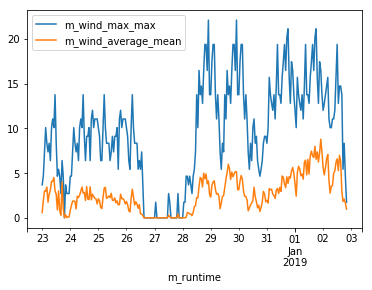

In [67]:
fig, ax = plt.subplots()
df_m.plot(ax = ax, x= 'm_runtime', y = 'm_wind_max_max');
df_m.plot(ax = ax, x= 'm_runtime', y = 'm_wind_average_mean');

##  Forecast Data

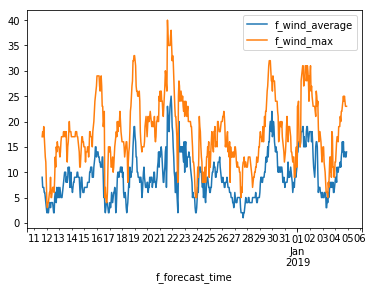

In [68]:
fig, ax = plt.subplots()
df_f.plot(ax = ax, x = 'f_forecast_time', y = 'f_wind_average');
df_f.plot(ax = ax, x = 'f_forecast_time', y = 'f_wind_max');

/home/magnus/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


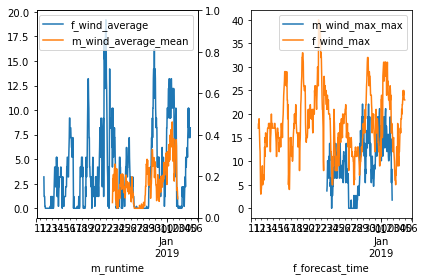

In [69]:
fig, ax = plt.subplots(1,2)
ax2 = ax[0].twinx()
df_f['f_wind_average'] -=5.8023209459459455
negatives = df_f['f_wind_average'] <0
df_f['f_wind_average'][negatives] = 0

#print(df_f[negatives]['f_wind_average'])
df_f.plot(ax = ax[0], x = 'f_forecast_time', y = 'f_wind_average');
df_m.plot(ax = ax[0], x= 'm_runtime', y = 'm_wind_average_mean');
#df_f.plot(ax = ax2, x= 'f_forecast_time', y = 'f_wind_angle', color ='r');

#ax2 = ax[1].twinx()

df_m.plot(ax = ax[1], x= 'm_runtime', y = 'm_wind_max_max');
df_f.plot(ax = ax[1], x = 'f_forecast_time', y = 'f_wind_max');

plt.tight_layout()

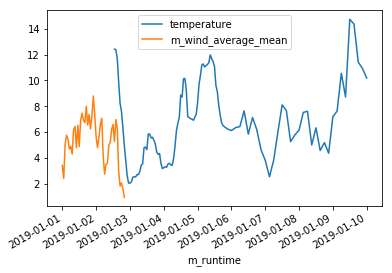

In [46]:
fig, ax = plt.subplots()
df.plot(ax = ax, y = 'temperature')
df_m.plot(ax = ax, x= 'm_runtime', y = 'm_wind_average_mean');

#df_f.plot(ax = ax, x = 'f_forecast_time', y = 'f_wind_average');

In [118]:
from netCDF4 import Dataset
from datetime import datetime
from datetime import timedelta
path_data = "/media/data/owncloud/code/julian_magnus/J_and_M/grib2/ICON_GLOBAL2WORLD_025_EASY/data/"

path = '/media/data/owncloud/code/julian_magnus/J_and_M/grib2/ICON_GLOBAL2WORLD_025_EASY/data/' 
file = path + 'icon_global_icosahedral_single-level_2019010200_004_T_2M.nc'
files = glob(join(path,'*.nc'))
times = []
temperature = []

longitude = 51.45
latitude = 8.4
for f in files:
    dataset = Dataset(f) 
    startTime = dataset.variables['time'].units[14:]
    minutes = dataset.variables['time'][:]
    time = (datetime.strptime(startTime, '%Y-%m-%d %H:%M:%S'))
    #print(minutes)
    #print())
    lon = dataset.variables['lon'][:]
    lat = dataset.variables['lat'][:]
    temp = dataset.variables['VMAX_10M'][:]
    temp = (temp[0,0,:,:])
    lonStart = 336
    lonEnd = 405
    latStart = 19
    latEnd = 70
    lonRange = ((lon > lonStart) & (lon < lonEnd ))
    latRange = ((lat > latStart) & (lat < latEnd ))
    
    times.append(time+timedelta(minutes = minutes[0]))
    l,lonRange = find_nearest(lon, longitude)
    print(l)
    la,latRange = find_nearest(lat, latitude)
    print(la)
    data = temp[latRange, lonRange]
    temperature.append(data)
    
arr = np.transpose(np.array([times, temperature]))
df = pd.DataFrame(arr, columns = ['time', 'temperature'])
df.time = pd.to_datetime(df.time)
df.index = df.time

336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5
336.5
29.5

In [117]:
def find_nearest(a, a0):
    return a[ np.abs(a - a0).argmin()],np.abs(a - a0).argmin()

find_nearest(lon,336.9)

(336.875, 6)

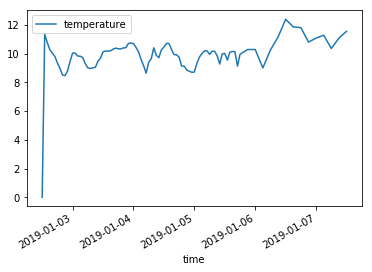

In [104]:
df.plot(y='temperature')

## Data analysis

In [81]:
f = pd.merge(df_m, df_f, left_on = 'm_runtime', right_on = 'f_forecast_time')


In [82]:
print(f['f_wind_average'].corr(f['m_wind_average_mean']))
print(f['f_wind_max'].corr(f['m_wind_max_max']))

0.4978880012544896
0.5554165394458737


# Deviation 

\begin{equation}
dev =  x_{f} - x_{m}
\end{equation}
We see that there is a strong bias towards overestimating the wind's strength. In average we are 6 knts off for the mean and 12 knts off for wind gusts

In [89]:
f['dif_mean'] = -(f['m_wind_average_mean']-f['f_wind_average'])

5.870173263939556


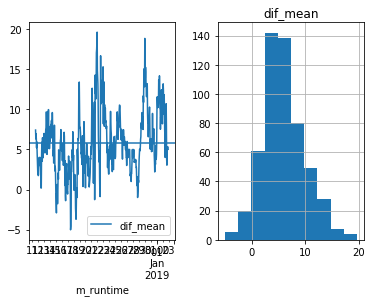

In [90]:
fig, ax = plt.subplots(1,2)
f.plot(ax = ax[0],x='m_runtime', y= 'dif_mean');
ax[0].axhline(np.average(f['dif_mean']))
print(np.average(f['dif_mean']))

f.hist(ax = ax[1], column = 'dif_mean');

In [87]:
f['dif_max'] = -(f['m_wind_max_max']-f['f_wind_max'])

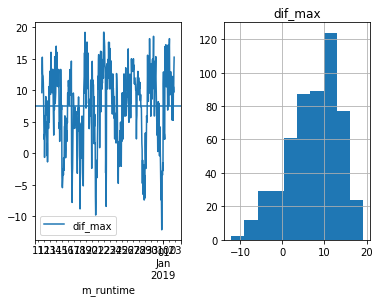

In [88]:
fig, ax = plt.subplots(1,2)
f.plot(ax = ax[0],x='m_runtime', y= 'dif_max');
ax[0].axhline(np.average(f['dif_max']))

f.hist(ax = ax[1],column = 'dif_max');

In [9]:
server = ftplib.FTP()
    
# DWD FTP server host name
server = "ftp-cdc.dwd.de"

# FTP server path for our files
serverpath = "/pub/CDC/observations_germany/climate/hourly"
# You don't have to print this, because this command itself prints dir contents 

user = "anonymous"
passwd = "guest@example.com"

ftp = FTP(server)
ftp.login(user, passwd)
ftp.dir()
ftp.cwd(serverpath)
#server.d11ir()#
ftp.dir()

drwxrwx---   3 32481    ftp-dwd      4096 May 24  2017 depr
drwxr-xr-x   4 root     root         4096 Jun 15  2016 pub
drwxr-xr-x   3 root     root         4096 Feb 14  2017 test
drwxrwx--x   4 32230    ftp-dwd      4096 Jun 22  2017 air_temperature
drwxrwx--x   4 32230    ftp-dwd      4096 Feb 28  2018 cloud_type
drwxrwx--x   4 32230    ftp-dwd      4096 Sep 25  2014 cloudiness
drwxrwx--x   4 32230    ftp-dwd      4096 Nov 13  2014 precipitation
drwxrwx--x   4 32230    ftp-dwd      4096 Nov 13  2014 pressure
drwxrwx--x   4 32230    ftp-dwd      4096 Jun  5  2014 soil_temperature
drwxrwx--x   2 32230    ftp-dwd     12288 Oct 23  2017 solar
drwxrwx--x   4 32230    ftp-dwd      4096 Jun  5  2014 sun
drwxrwx--x   4 32230    ftp-dwd      4096 Jan 15  2018 visibility
drwxrwx--x   4 32230    ftp-dwd      4096 Apr 17  2015 wind


In [2]:
from netCDF4 import Dataset

In [3]:
file = '/home/magnus/Downloads/FF_199501_CF.nc'
dataset = Dataset(file) 

In [4]:
print(dataset.file_format)

NETCDF3_CLASSIC


In [5]:
print(dataset.dimensions.keys())

odict_keys(['X', 'Y', 'time'])


In [12]:
print(dataset.variables['time'])

<class 'netCDF4._netCDF4.Variable'>
int32 time(time)
    units: hours since 1995-01-01 00:00:00
    long_name: time
    calendar: proleptic_gregorian
unlimited dimensions: time
current shape = (744,)
filling on, default _FillValue of -2147483647 used



In [1]:
import pygrib

In [45]:
file = '/home/magnus/Downloads/icon_global_icosahedral_model-level_2018121600_000_10_T.grib2' #example filename

path = '/home/magnus/Downloads/' 
file_name = 'icon_global_icosahedral_model-level_2018121600_015_52_T.grib2'
file_name = 'icon_global_icosahedral_model-level_2018121600_000_44_T.grib2'
file_name = 'icon-eps_global_icosahedral_time-invariant_2018121600_elat.grib2'

file_name = 'icon-eps_global_icosahedral_single-level_2018121600_000_t_2m.grib2'
#file_name = 'icon-eps_global_icosahedral_time-invariant_2018121600_elon.grib2'
gr = pygrib.open(path+file_name)

In [46]:
for g in gr:
    print(g)

1:2 metre temperature:K (instant):unstructured_grid:heightAboveGround:level 2 m:fcst time 0 mins:from 201812160000
2:2 metre temperature:K (instant):unstructured_grid:heightAboveGround:level 2 m:fcst time 0 mins:from 201812160000
3:2 metre temperature:K (instant):unstructured_grid:heightAboveGround:level 2 m:fcst time 0 mins:from 201812160000
4:2 metre temperature:K (instant):unstructured_grid:heightAboveGround:level 2 m:fcst time 0 mins:from 201812160000
5:2 metre temperature:K (instant):unstructured_grid:heightAboveGround:level 2 m:fcst time 0 mins:from 201812160000
6:2 metre temperature:K (instant):unstructured_grid:heightAboveGround:level 2 m:fcst time 0 mins:from 201812160000
7:2 metre temperature:K (instant):unstructured_grid:heightAboveGround:level 2 m:fcst time 0 mins:from 201812160000
8:2 metre temperature:K (instant):unstructured_grid:heightAboveGround:level 2 m:fcst time 0 mins:from 201812160000
9:2 metre temperature:K (instant):unstructured_grid:heightAboveGround:level 2 m:

In [47]:
print(gr[1])

1:2 metre temperature:K (instant):unstructured_grid:heightAboveGround:level 2 m:fcst time 0 mins:from 201812160000


In [25]:
gr.seek(1)

In [41]:
ha = (gr.select(name='edge midpoint latitude')[0])

In [48]:
ha = gr.select(name='2 metre temperature')[0]

In [49]:
maxt = ha['values']
maxt.shape, maxt.min(), maxt.max()

((327680,), 221.75747680664062, 310.4352111816406)

In [42]:
maxt = ha['values']

In [36]:
maxt.shape, maxt.min(), maxt.max()

((491520,), -180.0, 180.0)

In [43]:
maxt.shape, maxt.min(), maxt.max()

((491520,), -89.78477478027344, 89.78553771972656)

In [44]:
print(491520*491520)

241591910400
